## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center">Preprocessing</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading and Exploration](#dataloadandexpl)
    * [3.1. Data Loading](#data_loading)
    * [3.2. Validating File Paths](#val_file_path)
    * [3.3. Checking for Missing or Duplicate Values](#NaN_and_duplicates)
    * [3.4. Visualization](#visualization)
* [4. Train Test Split](#train_test_split)
* [5. Image Preprocessing](#image_preproc)
    * [5.1. Image Visualization](#image_visualization)
    * [5.2. Rescale and Resizing](#image_rescale)
    * [5.3. Image Duplicates](#image_duplicates)
    * [5.4. Channels](#image_channels)

In [13]:
#we can also connect to drive and have the images there 

# 1. Introduction <a class="anchor" id="intro"></a>

This project focuses on developing a deep learning model to classify rare species based on images. The dataset comes from the Encyclopedia of Life (EOL) and is curated as part of the *BioCLIP: A Vision Foundation Model for the Tree of Life* study. The full study is available in our repository [here](<Project Description/BioCLIP_study.pdf>).  
In this notebook, we will focus on setting up the environment and preprocessing the data. This includes loading the dataset, exploring its structure, splitting it into training, validation, and test sets, and applying necessary image transformations. These steps are crucial for ensuring that the model is trained effectively and generalizes well to new data.  

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs: []


In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

# Tensorflow for GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs: []


# 3. Data Loading & Exploration <a class="anchor" id="dataloadandexpl"></a>

## 3.1. Data Loading <a class="anchor" id="data_loading"></a>
In this section, we'll start by unzipping the dataset and loading the metadata CSV file. This allows us to explore the data and validate the image paths.

In [3]:
# Defining the paths
zip_path = "rare_species 1.zip"
extract_path = "rare_species"
csv_path = os.path.join(extract_path, "metadata.csv")  

# Extract the ZIP file 
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Now that we already extract the zip file let's check the metadata as well as checking the path.

In [4]:
# Load metadata CSV
df = pd.read_csv(csv_path, index_col="rare_species_id")
print("Metadata Loaded:")
df.head()

Metadata Loaded:


eol_content_id  eol_page_id   kingdom  \
rare_species_id                                                               
75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393  animalia   
28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083  animalia   
00372441-588c-4af8-9665-29bee20822c0        28895411       319982  animalia   
29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188  animalia   
94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886  animalia   

                                        phylum            family  \
rare_species_id                                                    
75fd91cb-2881-41cd-88e6-de451e8b60e2  mollusca         unionidae   
28c508bc-63ff-4e60-9c8f-1934367e1528  chordata       geoemydidae   
00372441-588c-4af8-9665-29bee20822c0  chordata  cryptobranchidae   
29cc6040-6af2-49ee-86ec-ab7d89793828  chordata          turdidae   
94004bff-3a33-4758-8125-bf72e6e57eab  chordata         indriidae   

                                                                              file_path  
rare_species_id                                                                          
75fd91cb-2881-41cd-88e6-de451e8b60e2  mollusca_unionidae/12853737_449393_eol-full-si...  
28c508bc-63ff-4e60-9c8f-1934367e1528  chordata_geoemydidae/20969394_793083_eol-full-...  
00372441-588c-4af8-9665-29bee20822c0  chordata_cryptobranchidae/28895411_319982_eol-...  
29cc6040-6af2-49ee-86ec-ab7d89793828  chordata_turdidae/29658536_45510188_eol-full-s...  
94004bff-3a33-4758-8125-bf72e6e57eab  chordata_indriidae/21252576_7250886_eol-full-s...

## 3.2. Validating File Paths <a class="anchor" id="val_file_path"></a>
The file paths in the dataset follow a specific structure based on the metadata columns. We will check that the file paths match this expected format:

- The folder name in the path should be a combination of the phylum and family.
- The filename should consist of the eol_content_id and eol_page_id.

In [5]:
# Function to check if file_path matches expected format
def validate_file_paths(df):
    mismatches = []
    
    for idx, row in df.iterrows():
        # Extract expected components
        expected_folder = f"{row['phylum']}_{row['family']}"
        expected_filename = f"{row['eol_content_id']}_{row['eol_page_id']}"

        # Extract actual components from file_path
        actual_parts = row["file_path"].split("/")
        
        if len(actual_parts) != 2:  # Ensure it follows the expected structure
            mismatches.append((idx, "Invalid path structure"))
            continue
        
        actual_folder, actual_filename = actual_parts
        actual_filename = actual_filename.split("_eol-")[0]  # Remove trailing parts

        # Check for mismatches
        if actual_folder != expected_folder or actual_filename != expected_filename:
            mismatches.append((idx, actual_folder, expected_folder, actual_filename, expected_filename))

    # Convert results to DataFrame for easy review
    if mismatches:
        mismatch_df = pd.DataFrame(mismatches, columns=["Index", "Actual Folder", "Expected Folder", "Actual Filename", "Expected Filename"])
        print("⚠️ Mismatches Found:")
        display(mismatch_df)
    else:
        print("✅ All file paths match the expected format.")

# Run validation
validate_file_paths(df)


✅ All file paths match the expected format.


## 3.3. Checking for Missing or Duplicate Values <a class="anchor" id="NaN_and_duplicates"></a>

In this section, we will check for missing values and duplicates in the metadata.

In [6]:
df.describe(include="O")

kingdom    phylum       family  \
count      11983     11983        11983   
unique         1         5          202   
top     animalia  chordata  dactyloidae   
freq       11983      9952          300   

                                                file_path  
count                                               11983  
unique                                              11983  
top     chordata_lemuridae/9465817_326525_eol-full-siz...  
freq                                                    1

In [7]:
# Check for duplicate values
print("\nNumber of duplicate rows:")
df.duplicated().sum()


Number of duplicate rows:


np.int64(0)


Missing Values: There are no missing values in the dataset.

Duplicates: There are no duplicate rows in the metadata. Each row is unique based on the rare_species_id index.

Value Distribution: By checking the frequency of the most common values in each column, we can observe how the categories are distributed.

Given that the data is clean (no missing values, no duplicates), we can now proceed to explore the distribution of our data visually to better understand the representation of species across different categories such as phylum and family.

## 3.4. Visualization <a class="anchor" id="visualization"></a>

Visualization is crucial in understanding  metadata. <br>

In [8]:
def plot_count_with_annotations(data, column, top_n=20, bottom_n=False, figsize=(6, 4)):
    '''
    Plot the distribution of classes in a specified column of a DataFrame, showing the top or bottom N classes.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data to plot.
    column (str): The column in the DataFrame for which the distribution will be plotted.
    top_n (int, optional): The number of top classes to display. Default is 20.
    bottom_n (bool, optional): Whether to show the bottom N classes instead of top N. Default is False.
    figsize (tuple, optional): The size of the figure (width, height). Default is (6, 4).
    
    Returns:
    None (displays the plot)
    '''
    # Get class counts
    class_counts = data[column].value_counts()
    
    # Get top N or bottom N classes
    if bottom_n:
        class_counts = class_counts.tail(top_n)  # bottom N
    else:
        class_counts = class_counts.head(top_n)  # top N
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=class_counts.index, y=class_counts.values)
    
    # Add annotations for each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',  # Format count without decimals
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')
    
    plt.title(f'Top {top_n} {column} Classes' if not bottom_n else f'Bottom {top_n} {column} Classes')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

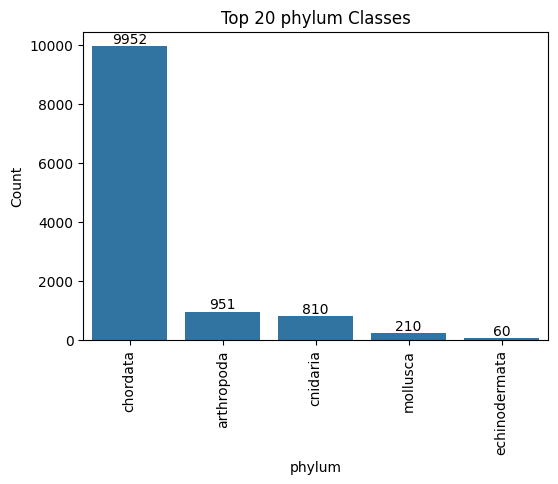

In [9]:
# Visualize the distribution of species across different phyla
plot_count_with_annotations(df, 'phylum', figsize=(6, 4))

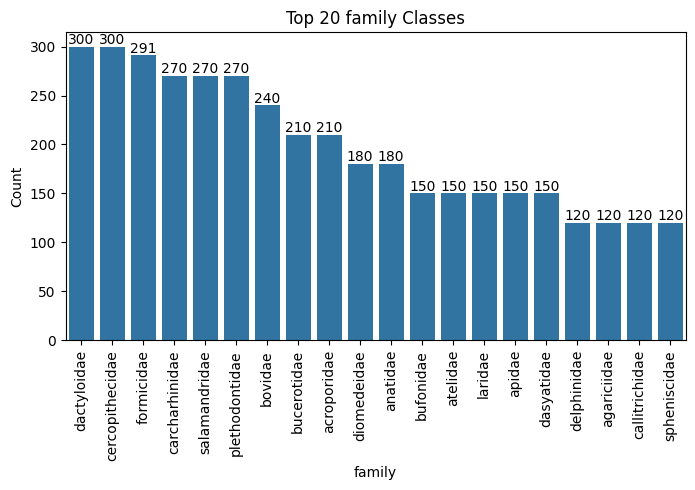

In [10]:
# Plot the top 20 families
plot_count_with_annotations(df, 'family', top_n=20, figsize=(8, 4))

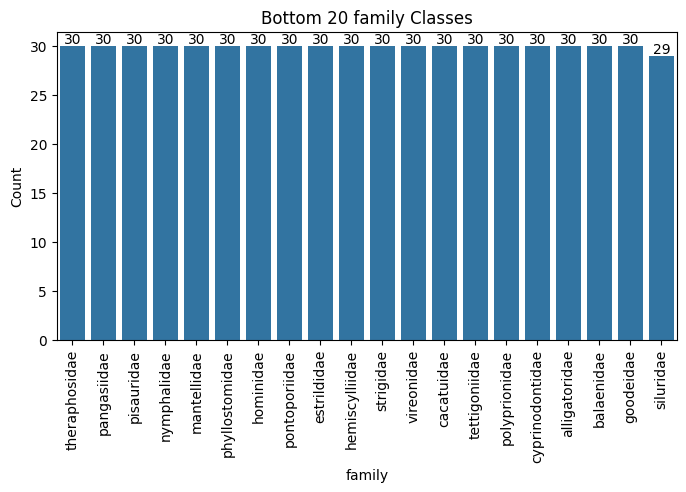

In [11]:
# Plot the bottom 20 families
plot_count_with_annotations(df, 'family', top_n=20, bottom_n=True, figsize=(8, 4))

We can also explore the distribution of family inside each phylum. 

In [12]:
def print_unique_families_per_phylum(data, phylum_column='phylum', family_column='family'):
    '''
    Print the count of unique families per phylum.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data.
    phylum_column (str, optional): The column for the phylum. Default is 'phylum'.
    family_column (str, optional): The column for the family. Default is 'family'.
    
    Returns:
    None (prints the counts)
    '''
    unique_families_per_phylum = data.groupby(phylum_column)[family_column].nunique()
    print("Unique Families per Phylum:")
    print(unique_families_per_phylum)

print_unique_families_per_phylum(df)

Unique Families per Phylum:
phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
Name: family, dtype: int64


In [20]:
# Check families with the fewest data
family_counts = df["family"].value_counts(ascending=True)
print("Families with the fewest data points:")
print(family_counts.head(20))

Families with the fewest data points:
family
siluridae           29
indriidae           30
nesospingidae       30
dasyuridae          30
glareolidae         30
pleuronectidae      30
gekkonidae          30
trogonidae          30
pittidae            30
daubentoniidae      30
alcedinidae         30
platystictidae      30
latimeriidae        30
sciuridae           30
caprimulgidae       30
gavialidae          30
cerambycidae        30
percidae            30
carettochelyidae    30
otididae            30
Name: count, dtype: int64


In [ ]:
def plot_family_distribution_by_phylum(data, phylum_column='phylum', family_column='family', 
                                       selected_phylum=None, top_n=20, figsize=(6, 4)):
    '''
    Plot the distribution of families within each phylum. 
    For a specific phylum (selected_phylum), show top N families, otherwise, show all families.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data to plot.
    phylum_column (str, optional): The column for the phylum. Default is 'phylum'.
    family_column (str, optional): The column for the family. Default is 'family'.
    selected_phylum (str, optional): The phylum for which to display top N families. Default is None (show all).
    top_n (int, optional): Number of top families to display for the selected phylum. Default is 20.
    figsize (tuple, optional): The size of the figure (width, height). Default is (12, 8).
    
    Returns:
    None (displays the plot)
    '''

    # Filter data for the selected phylum (if provided)
    if selected_phylum:
        selected_phylum_data = data[data[phylum_column] == selected_phylum]
        family_counts = selected_phylum_data[family_column].value_counts()

        # Get top N families for the selected phylum
        top_families = family_counts.head(top_n).index
        
        # Filter data for top N families of selected phylum
        filtered_data = selected_phylum_data[selected_phylum_data[family_column].isin(top_families)]
        
        # Plot top N families for selected phylum
        plt.figure(figsize=figsize)
        sns.countplot(data=filtered_data, x=family_column, order=top_families, color='skyblue')
        
        # Add count labels above each bar
        for p in plt.gca().patches:
            height = p.get_height()
            if height > 0:
                plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')

        plt.title(f'Families in Phylum {selected_phylum}')
        plt.xlabel(family_column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    else:
        # For all phyla, plot distribution without filtering top N
        plt.figure(figsize=figsize)
        sns.countplot(data=data, x=family_column, hue=phylum_column, color='skyblue')

        # Add count labels above each bar
        for p in plt.gca().patches:
            height = p.get_height()
            if height > 0:
                plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')

        plt.title('Family Distribution Across All Phyla')
        plt.xlabel(family_column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

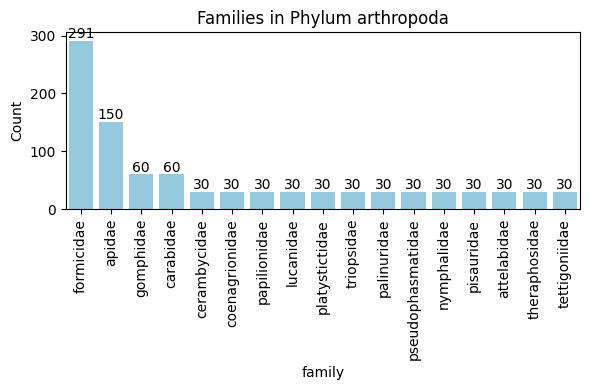

In [48]:
plot_family_distribution_by_phylum(df, selected_phylum="arthropoda")

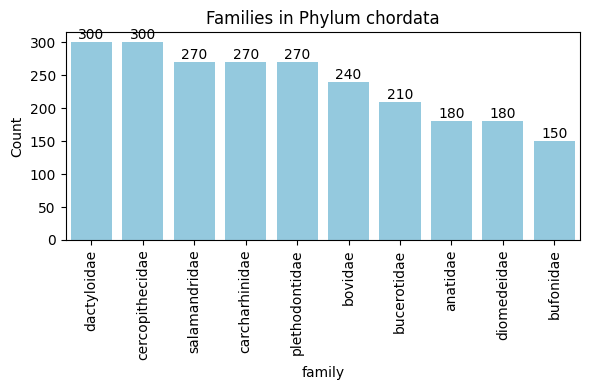

In [49]:
plot_family_distribution_by_phylum(df, selected_phylum="chordata", top_n=10)

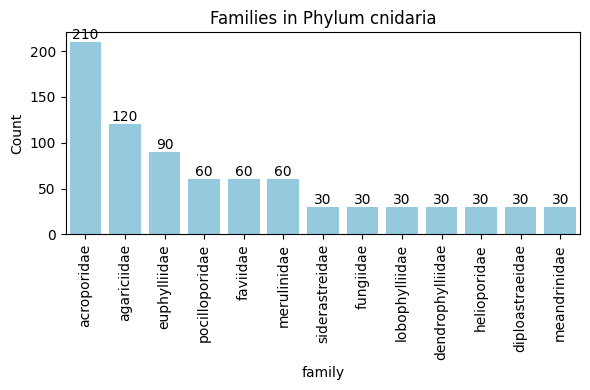

In [50]:
plot_family_distribution_by_phylum(df, selected_phylum="cnidaria")

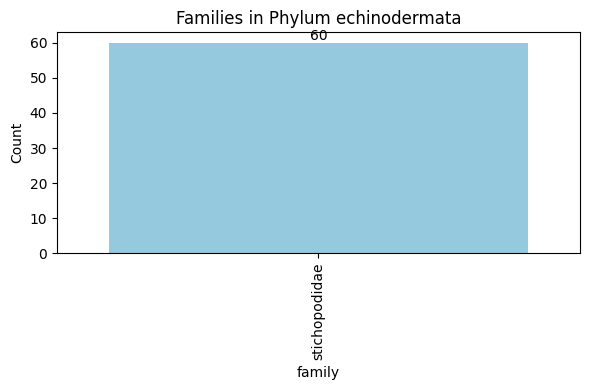

In [51]:
plot_family_distribution_by_phylum(df, selected_phylum="echinodermata")

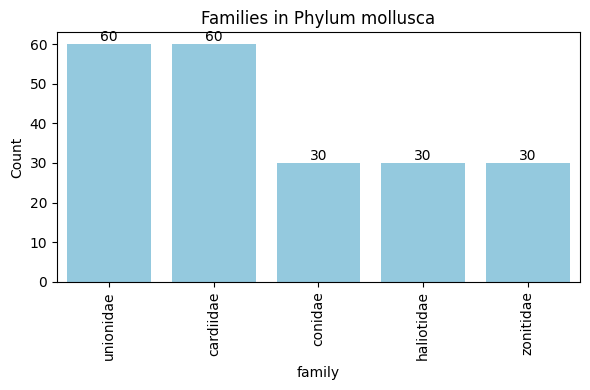

In [52]:
plot_family_distribution_by_phylum(df, selected_phylum="mollusca")

# 4. General Image Preprocessing <a class="anchor" id="image_preproc"></a>
Before splitting the images by phylum, we will randomly check some samples and perform general preprocessing.
## 4.1. Visualization <a class="anchor" id="image_visualization"></a>


To start lets run a code that will random display 5 mages for each phylum.

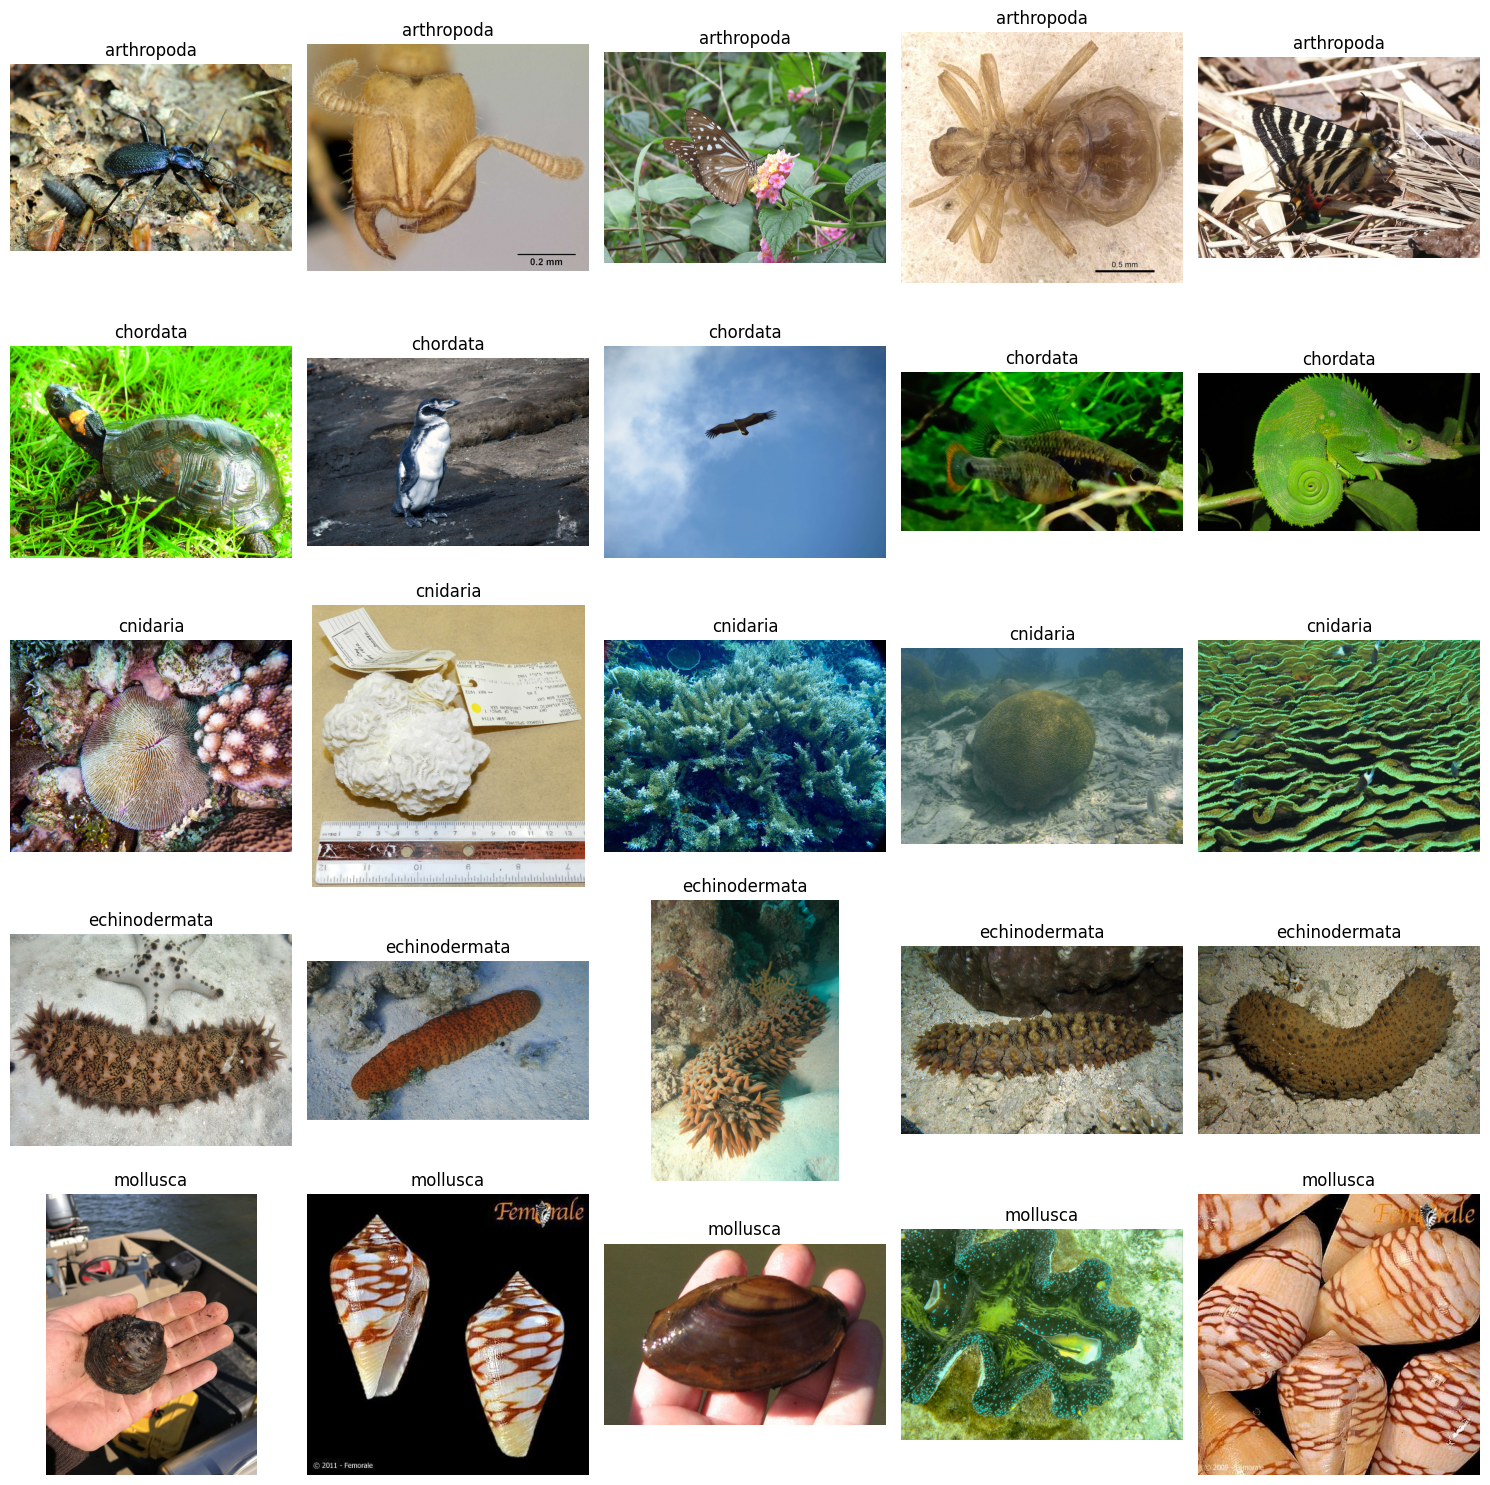

In [ ]:
def show_sample_images_by_phylum(df, image_folder, num_samples=5, figsize=(15, 15)):
    '''
    Display sample images for each phylum in a grid. 5 random samples for each phylum.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metadata and image paths.
    image_folder (str): The folder containing the image files.
    num_samples (int, optional): Number of images to display for each phylum. Default is 5.
    figsize (tuple, optional): The size of the figure. Default is (15, 15).
    
    Returns:
    None (displays the plot)
    '''
    # Group by phylum and sample `num_samples` images from each phylum
    phylum_groups = df.groupby('phylum')
    
    # Determine the number of rows and columns for the grid
    num_phyla = len(phylum_groups)
    rows = num_phyla
    cols = num_samples
    
    # Create a figure with a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Iterate through each phylum and display images
    for i, (phylum, group) in enumerate(phylum_groups):
        # Sample images for the current phylum
        sample_df = group.sample(min(num_samples, len(group)))
        
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join(image_folder, row['file_path'])
            ax = axes[i, j] if num_phyla > 1 else axes[j]
            
            if os.path.exists(img_path):
                image = Image.open(img_path)
                ax.imshow(image)
                ax.set_title(f'{row["phylum"]}')
            else:
                ax.set_title("Missing Image")
            ax.axis("off")
        
        # Set title for each phylum row
        axes[i, 0].set_ylabel(phylum, fontsize=12, rotation=0, labelpad=30)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

show_sample_images_by_phylum(df, extract_path, num_samples=5)

We have images of varying sizes across different phyla and even within each phylum. Since we've decided to split the dataset by phylum, we will handle the rescaling accordingly for each phylum.

Additionally, there are some general preprocessing steps we can apply:

- Detect duplicate images: identify and remove any duplicate images from the dataset to ensure we don't have redundant data.

- Check RGB channels: verify the number of channels in each image, as some images may have only two channels instead of the standard three (RGB).

- Identify letters in images: implement code to detect any text (letters) present within the images.

- Identify human beings

## 4.2. Image Duplicates <a class="anchor" id="image_ duplicates"></a>

Image hashing is a technique that converts an image into a unique or near-unique value (hash) based on its visual content. This allows for quick comparison between images, even if they are slightly altered (e.g., resized or rotated). By using image hashing, we can efficiently identify duplicate or near-duplicate images in a dataset without comparing every pixel, making it a useful tool for cleaning up large image datasets and avoiding redundancy.


In [ ]:
# !pip install ImageHash

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.3 MB 2.8 MB/s eta 0:00:02
   ------- -------------------------------- 0.8/4.3 MB 2.0 MB/s eta 0:00:02
   --------- ------------------------------ 1.0/4.3 MB 2.1 MB/s eta 0:00:02
   ------------ --------------------------- 1.3/4.3 MB 1.9 MB/s eta 0:00:02
   ----------------- ---------------------- 1.8/4.3 MB 1.7 MB/s eta 0:00:02
   ----------------- ---------------------- 1.8/4.3 MB 1.7 MB/s eta 0:00:02
   ---------------------- ----------------- 2.4/4.3 MB 1.6 MB/s eta 0:00:02
   --------------------------- ------------ 2.9/4.3 MB 1.7 MB/s eta 0:00:01
   ----------------------------- ---------- 3.1/4.3 MB 1.6 MB/s eta 0:00:01
   -------------------------------- ------- 3.4/4.3 MB 1.6 MB/s eta 0:00:01
   ---------------------------------- ----- 3.7/4.3 MB 1.6 MB/s eta 0:00:01
   ------------------------------------ --- 3.9/4.3 MB 1.6 MB/s eta 0:00:01
   ----------------

In [56]:
import pandas as pd
import imagehash
from PIL import Image
import os

def find_duplicate_images(df, image_folder):
    """
    Identify duplicate images in the dataframe based on their hash values.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metadata and image paths.
    image_folder (str): The folder containing the image files.
    
    Returns:
    duplicates (DataFrame): DataFrame containing the duplicates.
    """
    # Dictionary to store image hashes
    image_hashes = {}
    duplicates = []

    # Iterate through the dataframe and calculate hashes for each image
    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, row['file_path'])
        
        if os.path.exists(img_path):
            # Open the image
            img = Image.open(img_path)
            
            # Calculate the hash of the image (you can use different algorithms)
            img_hash = imagehash.phash(img)
            
            # Check if the hash already exists
            if img_hash in image_hashes:
                # If duplicate found, add to the duplicates list
                duplicates.append({
                    'original_image': image_hashes[img_hash],
                    'duplicate_image': img_path,
                    'hash': img_hash
                })
            else:
                # Store the hash with the image path
                image_hashes[img_hash] = img_path
    
    # Convert duplicates list to DataFrame for better visualization
    duplicates_df = pd.DataFrame(duplicates)
    
    return duplicates_df

duplicates_df = find_duplicate_images(df, extract_path)
if not duplicates_df.empty:
    print("Found duplicates:")
    print(duplicates_df)
else:
    print("No duplicates found.")

c:\Users\xandg\anaconda3\envs\deep_learning\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Found duplicates:
                                        original_image  \
0    rare_species\arthropoda_formicidae/29638873_88...   
1    rare_species\arthropoda_formicidae/29638449_47...   
2    rare_species\echinodermata_stichopodidae/22180...   
3    rare_species\chordata_fringillidae/22375404_45...   
4    rare_species\chordata_cercopithecidae/28745816...   
..                                                 ...   
156  rare_species\mollusca_unionidae/2744856_449459...   
157  rare_species\chordata_iguanidae/2833161_470445...   
158  rare_species\chordata_chelidae/12203_2815879_e...   
159  rare_species\chordata_chamaeleonidae/29608272_...   
160  rare_species\chordata_diomedeidae/30070655_455...   

                                       duplicate_image              hash  
0    rare_species\arthropoda_formicidae/14647056_88...  bb8794da4aa58c8e  
1    rare_species\arthropoda_formicidae/14608600_47...  8b2a74e13a33e58e  
2    rare_species\echinodermata_stichopodidae/14048...  985a

In [58]:
duplicates_df

original_image  \
0    rare_species\arthropoda_formicidae/29638873_88...   
1    rare_species\arthropoda_formicidae/29638449_47...   
2    rare_species\echinodermata_stichopodidae/22180...   
3    rare_species\chordata_fringillidae/22375404_45...   
4    rare_species\chordata_cercopithecidae/28745816...   
..                                                 ...   
156  rare_species\mollusca_unionidae/2744856_449459...   
157  rare_species\chordata_iguanidae/2833161_470445...   
158  rare_species\chordata_chelidae/12203_2815879_e...   
159  rare_species\chordata_chamaeleonidae/29608272_...   
160  rare_species\chordata_diomedeidae/30070655_455...   

                                       duplicate_image              hash  
0    rare_species\arthropoda_formicidae/14647056_88...  bb8794da4aa58c8e  
1    rare_species\arthropoda_formicidae/14608600_47...  8b2a74e13a33e58e  
2    rare_species\echinodermata_stichopodidae/14048...  985ad0340fb53d8f  
3    rare_species\chordata_fringillidae/2745972_455...  9e43537a39a3642d  
4    rare_species\chordata_cercopithecidae/11765_31...  bcc3d1191a7769c8  
..                                                 ...               ...  
156  rare_species\mollusca_unionidae/21566265_44945...  9cc4206ef9e38795  
157  rare_species\chordata_iguanidae/22552392_47044...  b1ccce73e4c89386  
158  rare_species\chordata_chelidae/28754499_281587...  e13f9ec392d06836  
159  rare_species\chordata_chamaeleonidae/29608263_...  c698616795378db8  
160  rare_species\chordata_diomedeidae/30070650_455...  b6a4c1d33f0cd0e3  

[161 rows x 3 columns]

In [ ]:
from PIL import Image
import IPython.display as display

# Loop through the DataFrame and display the original and duplicate images inside the notebook
for index, row in duplicates_df.iterrows():
    original_image_path = row['original_image']
    duplicate_image_path = row['duplicate_image']

    # Display the original image
    try:
        original_image = Image.open(original_image_path)
        display.display(original_image)
    except Exception as e:
        print(f"Error opening original image: {original_image_path}. Error: {e}")
    
    # Display the duplicate image
    try:
        duplicate_image = Image.open(duplicate_image_path)
        display.display(duplicate_image)
    except Exception as e:
        print(f"Error opening duplicate image: {duplicate_image_path}. Error: {e}")

KeyboardInterrupt: 

## 4.3. Channels <a class="anchor" id="image_ channels"></a>
Let's first check that they are all in the same 

In [57]:
from PIL import Image
import os

def check_image_channels(df, image_folder):
    """
    Check the number of channels for each image in the dataset.
    
    Parameters:
    df (DataFrame): The DataFrame containing image metadata.
    image_folder (str): The folder where the images are stored.
    
    Returns:
    None (prints out images with a different number of channels)
    """
    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, row['file_path'])
        if os.path.exists(img_path):
            try:
                image = Image.open(img_path)
                mode = image.mode
                channels = len(mode)  # For 'RGB' it will return 3, for 'L' it will return 1 (grayscale)
                
                if channels != 3:  # If the number of channels is not 3 (RGB)
                    print(f"Image {img_path} has {channels} channels (mode: {mode})")
            except Exception as e:
                print(f"Error with image {img_path}: {e}")

check_image_channels(df, "path_to_your_image_folder")

## 4.4. Channels <a class="anchor" id="image_ channels"></a>


# 5. Train Test Split  <a class="anchor" id="train_test_split"></a>

- we need to understand the code
- make train test split deterministic
- make sure that  we keep the % of y in train, test and val
- also we can do it with the metadata instead with the images



#split by phylum 
We first decided to split into phylum 

# only a test to see if this is working or not - this code is from 19/03 class

In [ ]:
# model training imports
# model building
from keras import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from typing import Any
# augmentation operations
from keras.layers import Rescaling, RandAugment

In [ ]:
class AugmentedVGG16(Model):
    """
    Pre-trained VG16 + RandAugment
    """

    def __init__(self: Any) -> None:
        """
        Initialization
        """

        super().__init__()

        self.n_classes = n_classes
        self.rescale_layer = Rescaling(scale=1 / 255.0)
        self.augmentation_layer = RandAugment(value_range=value_range)
        self.pre_trained_architecture = VGG16(include_top=False, classes=32) #include top means that the last layer is going to be removed,
        self.flatten_layer = Flatten()
        self.dense_layer = Dense(self.n_classes, activation="softmax")

    def call(self: Any, inputs: Any) -> Any:
        """
        Forward call
        """

        x = self.rescale_layer(inputs)
        x = self.augmentation_layer(x)
        x = self.pre_trained_architecture(x)
        x = self.flatten_layer(x)

        return self.dense_layer(x)

In [ ]:
# how RandAugment affects the image inputs?
from keras import Input
model= AugmentedVGG16()
input= Input((224,223,3))
_ = model.call(input)
model.summary()

Model: "augmented_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rand_augment (RandAugment)      │ (None, 224, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │     4,344,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,058,698 (72.70 MB)

 Trainable params: 19,058,698 (72.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 4
model = AugmentedVGG16()
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

In [ ]:
# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

In [ ]:
from src.utils import show_image

In [ ]:
from src.utils import exp_decay_lr_scheduler

In [ ]:
# callbacks
root_dir_path = Path(".")
checkpoint_file_path = root_dir_path / "checkpoint.keras"
metrics_file_path = root_dir_path / "metrics.csv"

checkpoint_callback = ModelCheckpoint(
    checkpoint_file_path,
    monitor="val_loss",
    verbose=0
)
metrics_callback = CSVLogger(metrics_file_path)
lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

callbacks = [
    checkpoint_callback,
    metrics_callback,
    lr_scheduler_callback
]

In [ ]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# train the model, call to the method is somewhat different
_ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/4


2025-03-28 01:25:47.889815: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27482112 exceeds 10% of free system memory.
2025-03-28 01:25:47.890318: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16196220 exceeds 10% of free system memory.
2025-03-28 01:25:47.890538: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47775744 exceeds 10% of free system memory.
2025-03-28 01:25:47.891404: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53747712 exceeds 10% of free system memory.
2025-03-28 01:25:48.007389: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48254976 exceeds 10% of free system memory.
I0000 00:00:1743121548.278895   79147 cuda_dnn.cc:529] Loaded cuDNN version 90300


743/743 - 123s - 165ms/step - accuracy: 0.0484 - auc: 0.6686 - f1_score: 0.0056 - loss: 4.9875 - val_accuracy: 0.0376 - val_auc: 0.6874 - val_f1_score: 0.0046 - val_loss: 5.0061 - learning_rate: 0.0095
Epoch 2/4
743/743 - 106s - 143ms/step - accuracy: 0.1024 - auc: 0.7623 - f1_score: 0.0276 - loss: 4.4795 - val_accuracy: 0.0886 - val_auc: 0.7911 - val_f1_score: 0.0245 - val_loss: 4.4681 - learning_rate: 0.0090
Epoch 3/4
743/743 - 103s - 138ms/step - accuracy: 0.1383 - auc: 0.8197 - f1_score: 0.0497 - loss: 4.0738 - val_accuracy: 0.1101 - val_auc: 0.8030 - val_f1_score: 0.0375 - val_loss: 4.2480 - learning_rate: 0.0086
Epoch 4/4
743/743 - 104s - 139ms/step - accuracy: 0.1823 - auc: 0.8616 - f1_score: 0.0953 - loss: 3.7172 - val_accuracy: 0.1441 - val_auc: 0.8409 - val_f1_score: 0.0680 - val_loss: 3.9280 - learning_rate: 0.0081


In [ ]:
# evaluate on the test ds
model.evaluate(
    test_ds,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.1402919888496399,
 'auc': 0.832283079624176,
 'f1_score': 0.06430218368768692,
 'loss': 3.972487211227417}